# Multiple Linear Regression using Numpy

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Load Boston Housing Data

In [2]:
boston = datasets.load_boston()
print(boston.keys())
print(boston['feature_names'])

dict_keys(['DESCR', 'data', 'target', 'feature_names'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [3]:
X_all = pd.DataFrame(boston.data, columns = boston['feature_names'])

# convert target to 2-d array
y = boston.target.reshape(len(boston.target), 1)

In [4]:
X_all.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
# select subset of data for modeling
#X = X_all[['CRIM', 'RM', 'AGE']].values
X = X_all.values

## Split into Training and Test Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7) 

## Apply Standard Scalar

* For multiple linear regression with no regularization, scaling your data is not a requirement, but it is good practice to include as a step when running ML algorithms
* Nice read on why the target does not need to be scaled:
https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re

In [7]:
# scale data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# mean of 0 std dev of 1
print(X_train_scaled[:,0].mean())
print(X_train_scaled[:,0].std())

4.067153654567405e-17
1.0


## Multiple Linear Regression Implementation

In [9]:
# https://datascience.stackexchange.com/questions/10188/why-do-cost-functions-use-the-square-error
def compute_cost(X, y, theta):
    
    #  (dot product of feature values and theta - true values)^2
    mse = np.square(((np.dot(X,theta.T))-y)).mean()
    return mse/2

In [10]:
def gradient_descent(X, y, theta, iters, alpha):
    cost = np.zeros(iters)
    for i in range(iters):
        
        theta = theta - (alpha/len(X)) * np.sum(X * (np.dot(X,theta.T) - y), axis=0)
        cost[i] = compute_cost(X, y, theta)
    
    return theta, cost

In [11]:
def train_mlr(X, y, param_grid):
    
    # append array of 1s
    ones = np.ones([X.shape[0],1])
    X = np.concatenate((ones,X),axis=1)
    
    # intialize theta
    theta = np.zeros([1,X.shape[1]])
    
    # gradient descent
    g, cost = gradient_descent(X, y, theta, param_grid['iters'], param_grid['alpha'])
    
    # compute final cost
    final_cost = compute_cost(X, y, g)
    
    print('Feature Weights: ', g)
    print('Final Cost: ', final_cost)
    
    return g, cost, final_cost


In [12]:
param_grid = {
    'alpha': 0.01,
    'iters': 1000
}
g, cost, final_cost = train_mlr(X_train_scaled, y_train, param_grid)

Feature Weights:  [[22.52155243 -0.87866251  0.53165989 -0.21054374  0.78402471 -1.34973106
   3.84057317 -0.34164872 -2.43342905  1.31061359 -1.00848321 -1.86543241
   0.88325216 -2.8423806 ]]
Final Cost:  9.916461197476048


## Plot Cost Plot

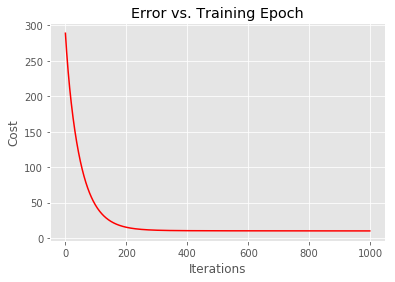

In [13]:
#plot the cost
fig, ax = plt.subplots()  
ax.plot(np.arange(param_grid['iters']), cost, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')  
plt.show()

## Test on Holdout Set

In [14]:
def compute_test_score(X, y, theta):
    # append array of 1s
    ones = np.ones([X.shape[0],1])
    X = np.concatenate((ones,X),axis=1)  
    
    # test cost
    test_cost = compute_cost(X, y, theta)
    print ('Test Cost ', test_cost)

In [15]:
compute_test_score(X_test_scaled, y_test, g)

Test Cost  17.504674586185534


# Construct Training vs Test Errors

### Prep Data

In [16]:
def scale(X_train, X_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [26]:
def split_scale(X, y):
    
    # split and scale
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7) 
    X_train, X_test = scale(X_train, X_test)
    
    return X_train, X_test, y_train, y_test
    

In [27]:
X_train, X_test, y_train, y_test = split_scale(X, y)

## Gradient Descent

In [28]:
def gradient_descent(X, y, X_test, y_test, theta, iters, alpha):
    cost = np.zeros(iters)
    test_cost = np.zeros(iters)
    for i in range(iters):
        
        theta = theta - (alpha/len(X)) * np.sum(X * (np.dot(X,theta.T) - y), axis=0)
        cost[i] = compute_cost(X, y, theta)
        test_cost[i] = compute_cost(X_test, y_test, theta)
    
    return theta, cost, test_cost

In [29]:
def train_mlr(X, y, X_test, y_test, param_grid):
    
    # append array of 1s
    ones = np.ones([X.shape[0],1])
    X = np.concatenate((ones,X),axis=1)
    
    ones = np.ones([X_test.shape[0],1])
    X_test = np.concatenate((ones,X_test),axis=1)  
    
    # intialize theta
    theta = np.zeros([1,X.shape[1]])
    
    # gradient descent
    g, cost, test_cost = gradient_descent(X, y, X_test, y_test, theta, param_grid['iters'], param_grid['alpha'])
    
    # compute final cost
    final_cost = compute_cost(X, y, g)
    
    print('Feature Weights: ', g)
    print('Final Cost: ', final_cost)
    
    return g, cost, test_cost, final_cost


In [30]:
param_grid = {
    'alpha': 0.01,
    'iters': 1000
}
g, cost, test_cost, final_cost = train_mlr(X_train, y_train, X_test, y_test, param_grid)

Feature Weights:  [[22.52155243 -0.87866251  0.53165989 -0.21054374  0.78402471 -1.34973106
   3.84057317 -0.34164872 -2.43342905  1.31061359 -1.00848321 -1.86543241
   0.88325216 -2.8423806 ]]
Final Cost:  9.916461197476048


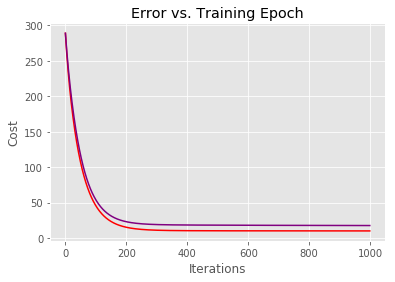

In [31]:
#plot the cost
fig, ax = plt.subplots()  
ax.plot(np.arange(param_grid['iters']), cost, 'r')  
ax.plot(np.arange(param_grid['iters']), test_cost, 'purple')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')  
plt.show()

In [32]:
compute_test_score(X_test, y_test, g)

Test Cost  17.504674586185534
